In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

tada_eta = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/LikeLion X Socar/data/tada_eta.xlsx')
print(tada_eta.columns)
tada_eta.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Index(['ATA', 'id', 'api_eta', 'created_at_kst', 'month', 'pickup_lng',
       'pickup_lat', 'pickup_gu', 'driver_id', 'driver_lng', 'driver_lat',
       'hour'],
      dtype='object')


,ATA,id,api_eta,created_at_kst,month,pickup_lng,pickup_lat,pickup_gu,driver_id,driver_lng,driver_lat,hour
0,10.60,R4L9FL6NVEL4D0,5.65,2019-12-01T00:55:09,12,127.091399,37.624545,노원구,DST52944,127.069978,37.616472,0
1,9.20,R3A7JBY7CS6TPD,8.60,2019-12-01T00:09:39,12,127.023351,37.625564,강북구,DPC72995,127.026479,37.604711,0
2,10.85,R2BIUY1TDK14XE,10.53,2019-12-15T00:18:42,12,126.881154,37.481641,금천구,DPP94923,126.906225,37.452167,0
3,5.52,R31PU5GNHSGU6C,1.92,2019-07-31T00:24:11,7,126.988375,37.567897,중구,DCT73585,126.991170,37.566416,0
4,8.60,R41WR6N1VT42DJ,7.10,2019-07-05T00:40:34,7,126.988684,37.566716,중구,DPJ86237,127.006860,37.571164,0


In [3]:
tada_eta['distance'] = ((tada_eta['pickup_lat']-tada_eta['driver_lat'])**2 + (tada_eta['pickup_lng']-tada_eta['driver_lng'])**2)*100000
tada_eta = tada_eta.drop(['id', 'created_at_kst', 'driver_id', 'pickup_lng', 'pickup_lat', 'driver_lng','driver_lat','pickup_gu'],1)
tada_eta.head()

# sklearn의 tree는 범주 데이터는 다루지 못함. 이 경우에 one-hot encoding은 비효율적. 구 데이터도 활용하고 싶다면 h2o 참고

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


,ATA,api_eta,month,hour,distance
0,10.60,5.65,12,0,52.400202
1,9.20,8.60,12,0,44.465889
2,10.85,10.53,12,0,149.731535
3,5.52,1.92,7,0,1.000535
4,8.60,7.10,7,0,35.014797


In [4]:
tada_eta = tada_eta.sample(frac=1).reset_index(drop=True)
tada_eta.head()

,ATA,api_eta,month,hour,distance
0,10.35,7.63,12,9,51.718353
1,7.45,8.38,12,21,22.668401
2,8.70,7.70,12,0,45.147863
3,7.03,3.03,12,21,2.230023
4,9.05,7.70,12,8,51.871181


In [5]:
tada_eta.shape

(13916, 5)

In [6]:
train = tada_eta[:12000]
test = tada_eta[12000:]

In [7]:
x_train = np.asarray(train.drop('ATA',1))
y_train = np.asarray(train['ATA'])
x_test = np.asarray(test.drop('ATA',1))
y_test = np.asarray(test['ATA'])
eta_features = [x for i,x in enumerate(tada_eta.columns) if i!=0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
eta_features

['api_eta', 'month', 'hour', 'distance']

In [102]:
params = {'n_estimators': 100,
          'max_depth': 3,
           'min_samples_leaf': 5,
          'learning_rate': 0.05,
          'random_state':0,
          'loss': 'ls'} # 'squared_error'와 같음

In [103]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import ensemble

In [104]:
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(x_train, y_train)

mse = mean_squared_error(y_test, reg.predict(x_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("The initial error of API ETA on test set: {:.4f}".format(mean_squared_error(y_test, x_test[:,0]) ))

mae = mean_absolute_error(y_test, reg.predict(x_test))
print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))
print("The initial error of API ETA on test set: {:.4f}".format(mean_absolute_error(y_test, x_test[:,0]) ))

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:290: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  FutureWarning,


The mean squared error (MSE) on test set: 8.9757
The initial error of API ETA on test set: 14.8165
The mean absolute error (MAE) on test set: 2.1044
The initial error of API ETA on test set: 2.7083


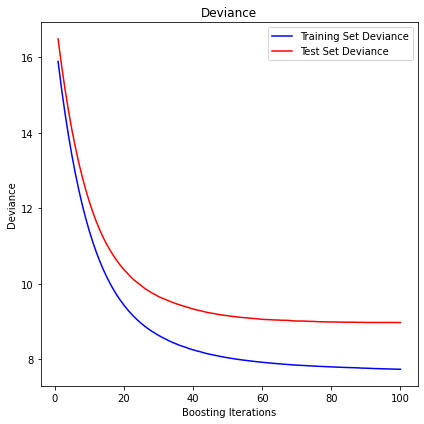

In [105]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(x_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, reg.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()

In [134]:
params = {'n_estimators': 300,
          'max_depth': 3,
          'min_samples_leaf': 5,
          'learning_rate': 0.02,
          'random_state':0,
          'loss': 'ls'} # 'squared_error'와 같음

In [135]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import ensemble

In [136]:
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(x_train, y_train)

mse = mean_squared_error(y_test, reg.predict(x_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("The initial error of API ETA on test set: {:.4f}".format(mean_squared_error(y_test, x_test[:,0]) ))

mae = mean_absolute_error(y_test, reg.predict(x_test))
print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))
print("The initial error of API ETA on test set: {:.4f}".format(mean_absolute_error(y_test, x_test[:,0]) ))

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:290: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  FutureWarning,


The mean squared error (MSE) on test set: 8.9480
The initial error of API ETA on test set: 14.8165
The mean absolute error (MAE) on test set: 2.1001
The initial error of API ETA on test set: 2.7083


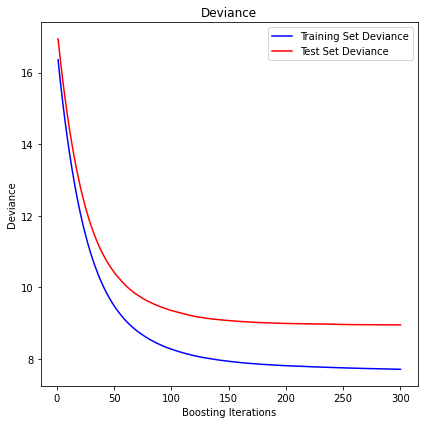

In [137]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(x_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, reg.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()